# Simulating a NVT Harmonic Oscillator using the Anderson Thermostat

## Model System
Hooke's law: $ F = -kx = ma $

Kinetic Energy: $ T(v) = \frac{mv^{2}}{2} $

Potential Energy: $ V(x) = \frac{kx^{2}}{2} $

System in contanct with heat bath of constant temperature to keep average kinetic energy constant such that:

$$ \left<v\right>^{2} = \frac{k T}{m} $$

Solve for **x** and **v** by going through time steps **dt**

At constant T the distribution of momentums is given by the Maxwell-Boltzmann Distribution: 

$$ \mathbb{P}(p) = \left(\frac{\beta}{2\pi m}\right)^{\frac{3}{2}} Exp\left[\frac{-\beta}{2m} \cdot p^{2}\right] $$

Or velocities:

$$ \mathbb{P}(v) = \left(\frac{m \beta}{2\pi}\right)^{\frac{3}{2}} Exp\left[\frac{-m \beta}{2} \cdot v^{2}\right] $$

where it's a normal distribution with $ \sigma = \sqrt{\frac{1}{m \beta}} $ and $ \beta = \left(k T\right)^{-1} $ for atomic particles

### Using Anderson Thermostat:

$$ \mathbb{P}(t,\nu) = \nu Exp\left[-\nu t\right] $$

where $ \mathbb{P}(t,\nu) $ is the distribution of time intervals between collisions with the heat bath and $ \nu $ is the frequency of collisions. Therefore $ \mathbb{P}(t,\nu)dt $ is the probability that the next collision will take place in $ [t,t+dt] $

$$ x(t + dt) = x(t) + v(t)dt + \frac{F(t)}{2m}dt^{2} $$

$$ v(t + dt) = v(t) + \frac{f(t + dt) + f(t)}{2m}dt = v(t) + \frac{f(t + dt)}{2m}dt + \frac{f(t)}{2m}dt = v(t + \frac{1}{2}dt) + \frac{f(t + dt)}{2m}dt $$

where 

$$ v(t + \frac{1}{2}dt) = v(t) + \frac{f(t)}{2m}dt $$

### Energies:

$$ T(t + dt) = \frac{m}{2} \cdot v(t + dt)^{2} $$

$$ V(t + dt) = \frac{k}{2} \cdot x(t + dt)^{2} $$

## Initialization

Imports:

In [1]:
%matplotlib inline
#%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
import pint
import matplotlib.pyplot as plt
import numpy as np

Standard Units:

In [2]:
rng = np.random.default_rng()
ureg = pint.UnitRegistry(auto_reduce_dimensions=True)
ureg.setup_matplotlib()
meter = ureg.meter
second = ureg.second
kilo = ureg.kilogram
Kel = ureg.kelvin
joule = ureg.joule

Global Constants:

In [9]:
#system constants
k = 20 * kilo/second**2
m = 20 * kilo #actually in amu
kb = 8313 * kilo * meter**2 / second**2 / Kel #actually kb/n where n is the conversion factor between amu and kg

#simulation conditions
dt = 0.1 * second
cycles = 10000
nu = 0.1 / second
nparts = 50
Ti = 300 * Kel
nbins = 30

## Definitions

In [4]:
#returns position after time delt using the velocity verlet method
def velVerPos(currPos,vel,force,delt):
    newPos = currPos + (vel * delt) + (force * delt**2 / 2 / m)
    return newPos

#returns velocity after time delt using the velocity verlet method with half timestep
def velVerVel(currVel,force, delt):
    newVel = currVel + (delt * force / 2 / m)
    return newVel

#returns force from position
def force(pos):
    f = -1 * k * pos
    return f

#returns kinetic energy from velocity
def kineticE(vel):
    KE = m / 2 * vel**2
    return KE

#returns potential energy from position
def potentialE(pos):
    PE = k / 2 * pos**2
    return PE

## Simulations

Anderson Thermostat:

In [5]:
#Initialize the arrays that will store the data
Pos = np.zeros(nparts) * meter
Vel = np.zeros(nparts) * meter/second

#Set initial values for the arrays and local variables
scf = np.sqrt(kb * Ti / m)
for i in range(nparts):
    Pos[i] = 2 * scf * np.sqrt(m / k) * (rng.random() - 0.5)
    Vel[i] = 2 * scf * (rng.random() - 0.5)
Vel = Vel - np.mean(Vel) / nparts
iPos = Pos.copy()
iVel = Vel.copy()

#MD loop
for i in range(cycles):
    for j in range(nparts):
        #sets force for current position
        frc = force(Pos[j])
        #update to new position and half velocity
        Pos[j] = velVerPos(Pos[j],Vel[j],frc,dt)
        Vel[j] = velVerVel(Vel[j],frc,dt)
        #update force for new position
        frc = force(Pos[j])
        #update for full new velocity
        Vel[j] = velVerVel(Vel[j],frc,dt)
        #test if collision with bath
        if rng.random() < nu*dt:
            Vel[j] = rng.normal(0,np.sqrt(kb * Ti / m).magnitude) * meter/second

#Check final system state
finalT = np.std(Vel)**2 * m / kb

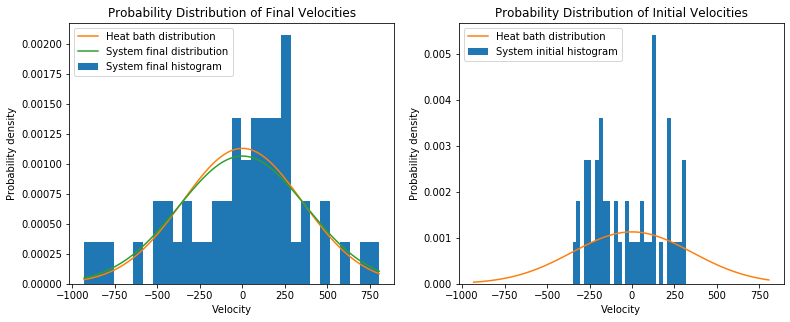

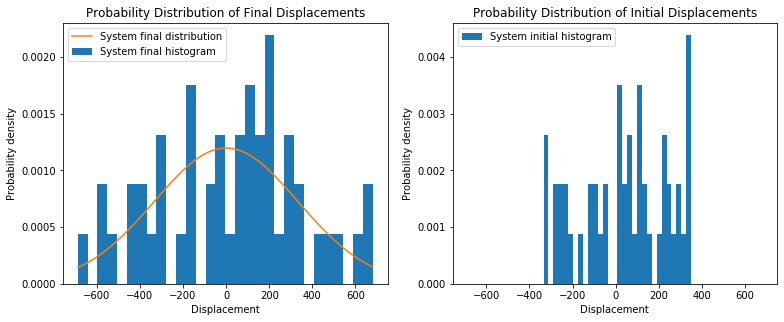

In [10]:
vs = np.linspace(np.amin(Vel), np.amax(Vel), 100)
ps = np.linspace(np.amin(Pos), np.amax(Pos), 100)

fig, aa = plt.subplots(1, 2, sharey=False, sharex=True, figsize=(6.4 * 2,4.8))
aa[0].hist(Vel, bins=nbins, density=True, label='System final histogram')
aa[0].plot(vs, (m / 2 / np.pi / kb / Ti)**0.5 * np.exp(-1 * m / 2 / kb / Ti * vs**2), label='Heat bath distribution')
aa[0].plot(vs, (1 / 2 / np.pi)**0.5 / np.std(Vel) * np.exp(-1 / 2 * vs**2 / np.std(Vel)**2), label='System final distribution')
aa[1].hist(iVel, bins=nbins, density=True, label='System initial histogram')
aa[1].plot(vs, (m / 2 / np.pi / kb / Ti)**0.5 * np.exp(-1 * m / 2 / kb / Ti * vs**2), label='Heat bath distribution')

plt.setp(aa[:], xlabel='Velocity', ylabel='Probability density')
aa[0].set_title('Probability Distribution of Final Velocities')
aa[1].set_title('Probability Distribution of Initial Velocities')
aa[0].legend()
aa[1].legend()

fig, ab = plt.subplots(1, 2, sharey=False, sharex=True, figsize=(6.4 * 2,4.8))
ab[0].hist(Pos, bins=nbins, density=True, label='System final histogram')
ab[0].plot(ps, (1 / 2 / np.pi)**0.5 / np.std(Pos) * np.exp(-1 / 2 * ps**2 / np.std(Pos)**2), label='System final distribution')
ab[1].hist(iPos, bins=nbins, density=True, label='System initial histogram')

plt.setp(ab[:], xlabel='Displacement', ylabel='Probability density')
ab[0].set_title('Probability Distribution of Final Displacements')
ab[1].set_title('Probability Distribution of Initial Displacements')
ab[0].legend()
ab[1].legend()

In [11]:
hist, bin_edges = np.histogram(Vel.magnitude, bins=nbins, density=True)
bincenters = np.mean(np.vstack([bin_edges[0:-1],bin_edges[1:]]), axis=0)
data = dict(zip(bincenters * meter/second, hist * second/meter))
temp = 0
for i in data.keys():
    temp += np.absolute(data[i] - (m / 2 / np.pi / kb / Ti)**0.5 * np.exp(-1 * m / 2 / kb / Ti * i**2))
mae = temp / nbins

cVel = np.array_split(Vel.magnitude, nbins)
means = np.zeros(nbins) * Vel.units
for i in range(nbins):
    means[i] = np.mean(cVel[i]) * Vel.units
stderrV = np.std(means) / np.sqrt(nbins)

cPos = np.array_split(Pos.magnitude, nbins)
means = np.zeros(nbins) * Pos.units
for i in range(nbins):
    means[i] = np.mean(cPos[i]) * Pos.units
stderrP = np.std(means) / np.sqrt(nbins)

print(f"Final temperature: {finalT:~.4} \nStandard error in velocity: {stderrV:~.4} \nStandard error in displacement: {stderrP:~.4} \nMean absolute error in velocity: {mae:~.3e}")

Final temperature: 337.3 K 
Standard error in velocity: 54.93 m / s 
Standard error in displacement: 54.98 m 
Mean absolute error in velocity: 3.038e-04 s / m
